Problem statement


 Itr:	 1
loss: 6.814


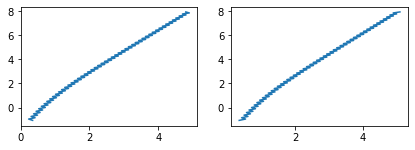


 Itr:	 2
loss: 3.380


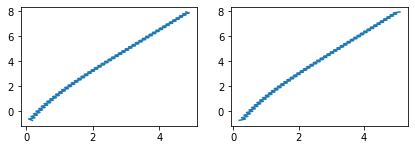


 Itr:	 3
loss: 2.162


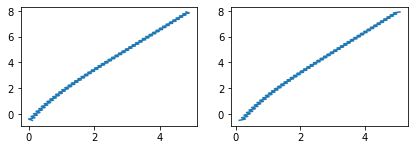


 Itr:	 4
loss: 1.630


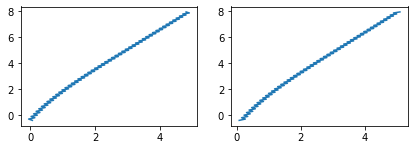


 Itr:	 5
loss: 1.361


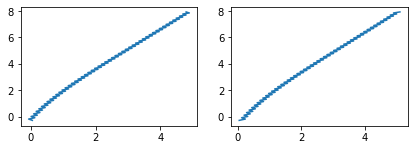


 Itr:	 6
loss: 1.214


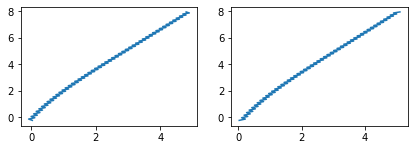


 Itr:	 7
loss: 1.128


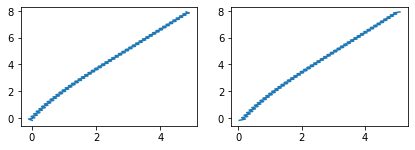


 Itr:	 8
loss: 1.076


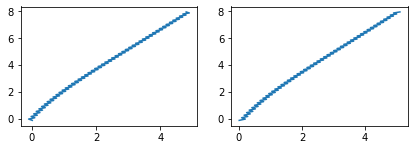


 Itr:	 9
loss: 1.044


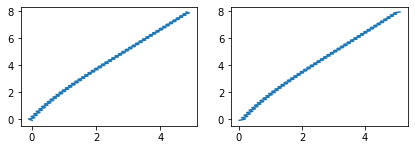


 Itr:	 10
loss: 1.024


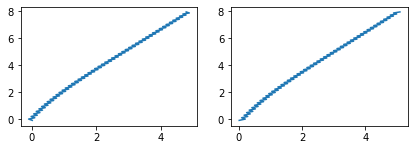


 Itr:	 11
loss: 1.014


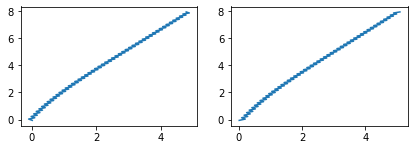


 Itr:	 12
loss: 1.008


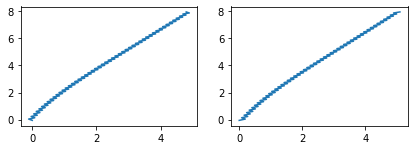


 Itr:	 13
loss: 1.005


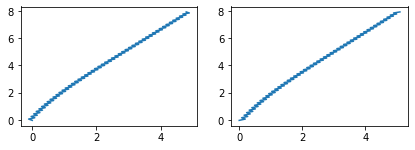


 Itr:	 14
loss: 1.003


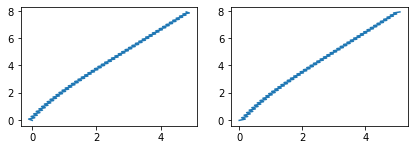


 Itr:	 15
loss: 1.002


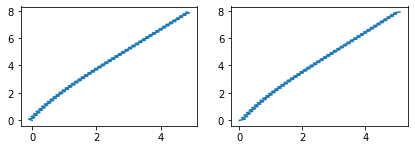


 Itr:	 16
loss: 1.001


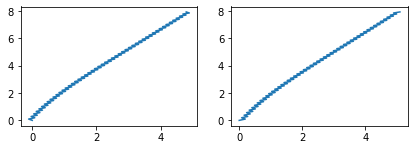


 Itr:	 17
loss: 1.001


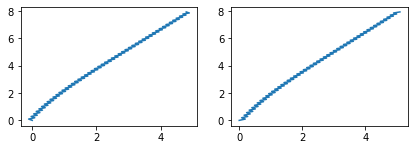


 Itr:	 18
loss: 1.000


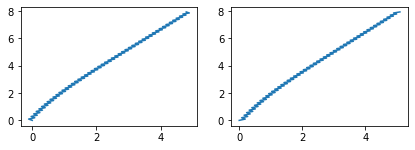


 Itr:	 19
loss: 1.000


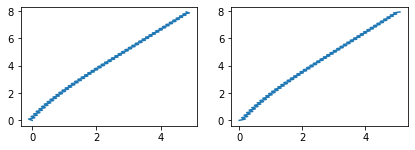


 Itr:	 20
loss: 1.000


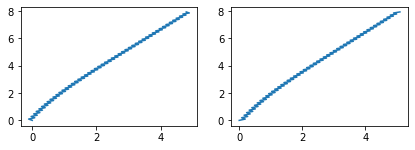


 Itr:	 21
loss: 1.000


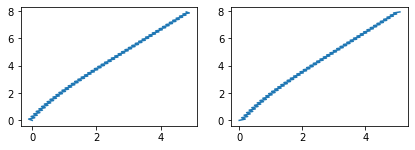


 Itr:	 22
loss: 1.000


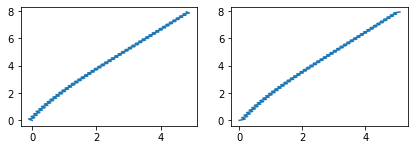


 Itr:	 23
loss: 1.000


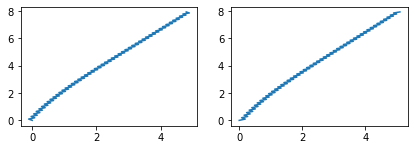


 Itr:	 24
loss: 1.000


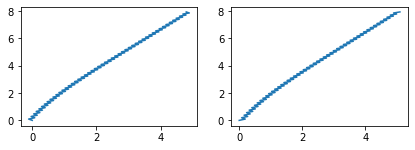


 Itr:	 25
loss: 1.000


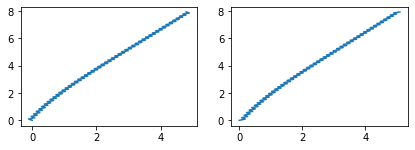


 Itr:	 26
loss: 1.000


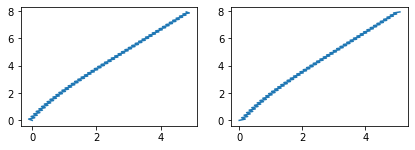


 Itr:	 27
loss: 1.000


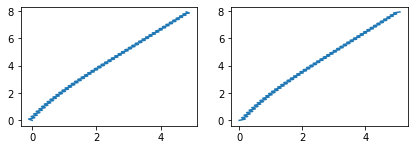


 Itr:	 28
loss: 1.000


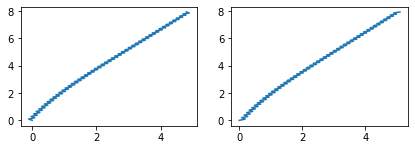


 Itr:	 29
loss: 1.000


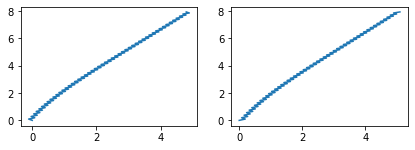


 Itr:	 30
loss: 1.000


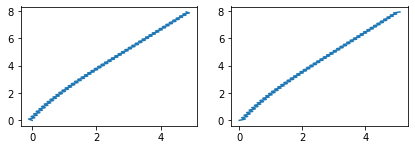


 Itr:	 31
loss: 1.000


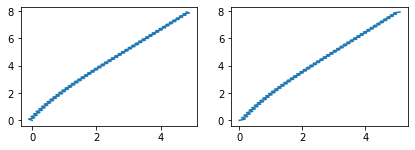


 Itr:	 32
loss: 1.000


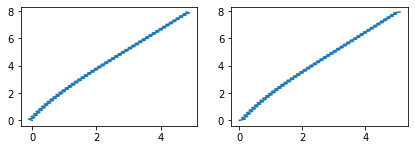


 Itr:	 33
loss: 1.000


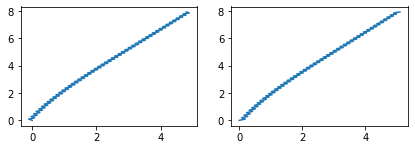


 Itr:	 34
loss: 1.000


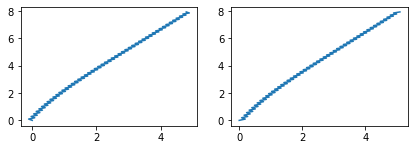


 Itr:	 35
loss: 1.000


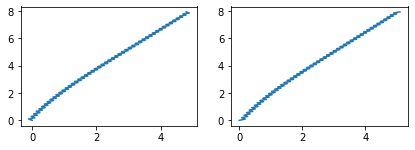


 Itr:	 36
loss: 1.000


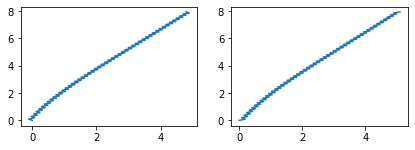


 Itr:	 37
loss: 1.000


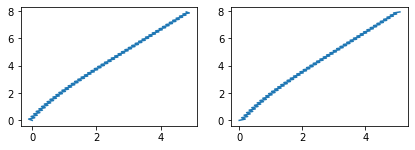


 Itr:	 38
loss: 1.000


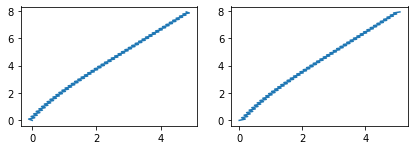


 Itr:	 39
loss: 1.000


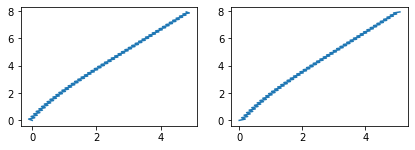


 Itr:	 40
loss: 1.000


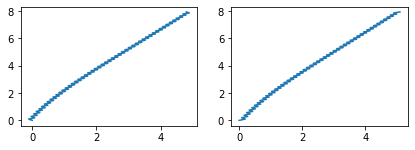

In [33]:
# overhead

import logging
# import math
# import random
import numpy as np
# import time
import torch as t
import torch.nn as nn
from torch import optim
# from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

Time_step = 0.01  # time interval
Gra_acc = 9.81  # gravity constant
Thruster_acc = 20.0  # thrust constant converges only for 15

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

"""Constraint 1: Trying to include drag in y direction (upward) but it's going to e less then the thrust"""
"""Constraint 2: Including the crosswind as a randomness variable"""
"""Constraint 3: This constraint is sort of side counter thrust to crosswind which acts
with 90% the power of crosswind because if its same as cross wind it basically cancels each other"""


class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: there are three of them
        action[0]: take off or landing thrust in y direction range (0, 1)
        action[1]: cross wind velocity in x direction range (-1, 1)
                -1 - cross wind to the left // 0 - no cross wind // 1 - cross wind to the right
        action[2]: counter side thrust to cross wind but at 90% power range (-1, 1)
                -1 - side thrust to the right // 0 - no side thrust // 1 - side thrust to left
        state[0] = x // state[1] = v_x // state[2] = x // state[3] = 0.9*v_x // state[4] = y // state[5] = v_y
        """
        vertical_thrust_y = action[0]
        crosswind = action[1]
        side_c_thrust = action[2]
        # drag = action[3]
        # Apply gravity
        del_state_gravity = -t.tensor([0., 0., 0., 0., 0., Gra_acc * Time_step])
        del_state_y = Thruster_acc * Time_step * t.tensor([0., 0., 0., 0., 0., -1.]) * action[0]
        # del_state_x = Thruster_acc * Time_step * t.tensor([0., 0., 0., 1.]) * action[1]
        # Thrust # Note: Same reason as above. Need a 2-by-1 tensor.
        temp = del_state_y
        d_decel = 0.00658 * temp * temp
        net_acc = Thruster_acc - d_decel
        del_state_vertical = net_acc * Time_step * t.tensor([0., 0., 0., 0., 0., -1.]) * vertical_thrust_y  # 1
        del_state_crosswind = net_acc * Time_step * t.tensor([0., 1., 0., 0., 0., 0.]) * crosswind  # 2
        # del_state_crosswind_l = Thruster_acc * Time_step * t.tensor([0., -1., 0., 0., 0., 0.]) * action[
        #     1] * crosswind  # 3
        del_state_side_thrust = 0.9 * (net_acc * Time_step * t.tensor([0., 0., 0., -1., 0., 0.]) * side_c_thrust)  # 4
        # del_state_side_thrust_r = Thruster_acc * Time_step * t.tensor([0., 0., 0., 1., 0., 0.]) * action[
        #     2] * side_c_thrust  # 5
        # Update velocity
        # state = state + del_state_vertical + del_state_crosswind + del_state_crosswind_l + del_state_side_thrust_r + del_state_side_thrust + del_state_gravity  # drag part goes in here

        state = state + del_state_vertical + del_state_crosswind + del_state_side_thrust + del_state_gravity  # drag part goes in here
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible.
        # Do not use element-wise operators as they are considered inplace.
        # step_mat = t.tensor([[1., 0., 0., 0., 0., 0.],
        #                      [Time_step, 1., 0., 0., 0., 0.],
        #                      [0., 0., 1., 0., 0., 0.],
        #                      [0., 0., Time_step, 1., 0., 0.],
        #                      [0., 0., 0., 0., 1., 0.],
        #                      [0., 0., 0., 0., Time_step, 1.]])
        step_mat = t.tensor([[0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., Time_step, 1.],
                             [0., 0., 1., 0., 0., 0.],
                             [0., 0., Time_step, 1., 0., 0.],
                             [1., 0., 0., 0., 0., 0.],
                             [Time_step, 1., 0., 0., 0., 0.]])
        state = t.matmul(step_mat, state)

        return state

        # print(type(state))


# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or
# deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time


class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        #  state 0   1   2   3   4   5
        state = [0, 5., -1., 8., 0., 5.]  # need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    @staticmethod
    def error(state):
        return state[0] ** 2 + 10 * state[1] ** 2 + state[2] ** 2 + 4 * state[3] ** 2 + state[4] ** 2 + state[5] ** 2


# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial
#    states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('\n Itr:\t',epoch + 1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
#         print(data)
        x = data[:, 1]
        y = data[:, 3]
        a = data[:, 5]
        b = data[:, 3]
        
        plt.figure()
        plt.subplot(221)
        plt.plot(x, y)
        
        plt.subplot(222)
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()
        
#         plt.plot(x, y)
#         plt.show()
#         if o == 40:
#             data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
#             x = data[:, 0]
#             y = data[:, 1]
#             plt.plot(x, y)
#             plt.show()


# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem
# print(s)
# print(type(s))
# print(d)
# print(c)


# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 